In [1]:
import musif
# from musif.config import ExtractConfiguration

In [2]:
import urllib.request
import zipfile
from pathlib import Path

data_dir = Path("data_poprock")
dataset_path = "dataset.zip"
urllib.request.urlretrieve("https://figshare.com/ndownloader/articles/5436031/versions/1", dataset_path)
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [3]:
# musif.extract.constants contains various constants useful to access the `data` dictionary
import musif.extract.constants as C

# the following list is specific to this dataset
drums_list = ['drumset', 'tambourine', 'drum', 'concert snare drum', 'hi-hat', 'automobile brake drums']

# a hook is any object that contains a `execute(cfg, data)` method
class RemoveDrums:
    def execute(cfg, data):
        # let's get the list of parts
        parts = list(data[C.DATA_FILTERED_PARTS])
        # C.DATA_SCORE is a music21.stream.Score object
        drums = [i for i in data[C.DATA_SCORE].parts if i._partName.split(',')[0].lower() in drums_list]
        # remove all the drums from the score
        data[C.DATA_SCORE].remove(drums)
        # reset the list of parts in the dictionary
        data[C.DATA_FILTERED_PARTS] = tuple([p for p in parts if p not in drums])
        # return the data
        return data

In [4]:
class RenameSimilarParts:
    def execute(cfg, data):
        parts = list(data[C.DATA_FILTERED_PARTS])
        part_names = set()
        counter = 1
        for part in data[C.DATA_SCORE].parts:
            
            # If the part is already in part_names set, we must change its partName, Abbreviation and Id
            if part.partName in part_names:
                part.partName = part.partName + f'({counter})'
                part.partAbbreviation = part.partAbbreviation + f'({counter})'
                part.id = part.id+ f'({counter})'
                counter += 1
                part_names.add(part.partName)
            else:
                part_names.add(part.partName)
        # By altering the part object of music21, the change its already reflected also in the parts list.       
        data[C.DATA_FILTERED_PARTS] = tuple(parts)
        return data

In [5]:
from ntpath import basename
from musif.musicxml.tempo import get_number_of_beats
import musif.extract.constants as C
from musif.extract.features.core.constants import DATA_NOTES_AND_RESTS, DATA_MEASURES
from musif.extract.features.tempo.constants import TIME_SIGNATURE
from musif.extract.features.prefix import get_part_feature

In [6]:
VOICE_SILENCE_BEATS = 'voice_silence_beats'

class custom_feature_package:
    class voice_silence_beats:
        """
        This feature calculates the number of beats the voice is in silence over the total of the song
        """
        class handler:
            def update_part_objects(
                score_data: dict = None,
                part_data: list = None,
                cfg: object = None,
                parts_features: list = None,
            ):
                # We will extract the number of beats that voice parts are in silence and 
                # divide it by the total number of beats. First we need to filter only voice/singer parts. 
                if part_data[C.DATA_FAMILY] == 'voice':
                    rests = [i for i in part_data[DATA_NOTES_AND_RESTS] if i.isRest]
                    rests_duration = sum([i.quarterLength for i in rests])
                    number_of_measures = score_data[DATA_MEASURES]
                    total_beats = get_number_of_beats(score_data[TIME_SIGNATURE]) * number_of_measures
                    voice_silence = rests_duration / total_beats
                    parts_features[get_part_feature(part_data[C.DATA_PART_ABBREVIATION], VOICE_SILENCE_BEATS)] = voice_silence
                else:
                    pass
            def update_score_objects(
                score_data: dict = None,
                parts_data: list = None,
                cfg: object = None,
                parts_features: list = None,
                score_features: dict = None,
            ):
                # Finally, we need to add the data to score_features, 
                # the dictionary where all final info is stored. 
                # Otherwise it will not be reflected in the final dataframe.
                features = {}
                for i, part_data in enumerate(parts_data):
                    if part_data[C.DATA_FAMILY] == 'voice':
                        part_abbreviation = part_data[C.DATA_PART_ABBREVIATION]
                        feature_name = get_part_feature(part_abbreviation, VOICE_SILENCE_BEATS)
                        features[feature_name]=parts_features[i][get_part_feature(part_abbreviation, VOICE_SILENCE_BEATS)]
                score_features.update(features)

class custom_basic_module:
    class custom_file_name:
        "set up artist and title from the file name"
        class handler:
            
            def update_score_objects(
                score_data,
                parts_data,
                cfg,
                parts_features,
                score_features
            ):
                chunks = basename(score_data[C.DATA_FILE]).split('.')
                artist = chunks[0]
                title = chunks[-1]

                score_features.update(
                    {
                        'Artist': artist,
                        'Title': title,
                    }
                )

            def update_part_objects(
                score_data, part_data, cfg, part_features
            ):
                pass

In [7]:
from musif.config import ExtractConfiguration


In [8]:
config = ExtractConfiguration(
    None,
    musescore_dir="data_poprock",
    # First, we tell musif where the features are
    # We can pass our custom features as python variables or as a strings that is importable by __import__
    feature_modules_addresses=["musif.extract.features", custom_feature_package], 
    basic_modules_addresses=["musif.extract.basic_modules", custom_basic_module],
    # Now, we list the features that we want to extract 
    basic_modules=['scoring', "custom_file_name"],
    features=["core", "ambitus", "melody", "tempo", 
            "density", "texture", "lyrics", "scale", 
            "key", "dynamics", "rhythm", 
            "voice_silence_beats"],
    # As for features, hooks can be expressed as variables or as strings that can imported by __import__
    precache_hooks=[RemoveDrums, RenameSimilarParts], 
    # window size is 8 measures with overlap of 50%
    window_size=8, overlap=4,
    # we also activate the cache: in this directory musif will put some pickled objects 
    # that it will reload at the next extraction
    cache_dir='__tutorial_cache'
)

In [9]:
from musif.extract.extract import FeaturesExtractor

extractor = FeaturesExtractor(config)

Cache activated!


In [10]:
import musif.musescore.constants as musescore_c
musescore_c.MUSESCORE_FILE_EXTENSION = '.mid'

In [11]:
# extrac = FeaturesExtractor(
#     ExtractConfiguration('/Users/ivansimo/Desktop/ICCMU/ICCMU_CODE/musicXXI/MUSIF/config_extraction_example.yml'),
#     xml_dir = '/Users/ivansimo/Desktop/ICCMU/ICCMU_CODE/musicXXI/MUSIF/data/AnatomyComposerAttributionMIDIFilesAndFeatureData_1_0/MIDI',
#     musescore_dir = '/Users/ivansimo/Desktop/ICCMU/ICCMU_CODE/musicXXI/MUSIF/data/AnatomyComposerAttributionMIDIFilesAndFeatureData_1_0/MIDI/Ib_noPen',
# ).extract()

In [12]:
df = extractor.extract()

  0%|          | 0/25 [00:00<?, ?it/s]/Users/ivansimo/Documents/MUSIF_rep/musif/musif/extract/features/melody/handler.py:592: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew(absolute_numeric_intervals, bias=False)
/Users/ivansimo/Documents/MUSIF_rep/musif/musif/extract/features/melody/handler.py:597: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis(absolute_numeric_intervals, bias=False)
  4%|▍         | 1/25 [00:10<04:01, 10.08s/it]

KeyboardInterrupt: 

In [ ]:
df

Artist  FamilyElectric_Density  FamilyElectric_Notes  \
0  0         Enya                     0.0                     0   
   1         Enya                     0.0                     0   
   2         Enya                     0.0                     0   
   3         Enya                     0.0                     0   
   4         Enya                     0.0                     0   
...           ...                     ...                   ...   
24 6   TheBeatles                    <NA>                  <NA>   
   7   TheBeatles                    <NA>                  <NA>   
   8   TheBeatles                    <NA>                  <NA>   
   9   TheBeatles                    <NA>                  <NA>   
   10  TheBeatles                    <NA>                  <NA>   

       FamilyElectric_NotesMean  FamilyElectric_NumberOfFilteredParts  \
0  0                        0.0                                     1   
   1                        0.0                                     1   
   2                        0.0                                     1   
   3                        0.0                                     1   
   4                        0.0                                     1   
...                         ...                                   ...   
24 6                       <NA>                                  <NA>   
   7                       <NA>                                  <NA>   
   8                       <NA>                                  <NA>   
   9                       <NA>                                  <NA>   
   10                      <NA>                                  <NA>   

       FamilyElectric_NumberOfParts  FamilyElectric_SoundingDensity  \
0  0                              1                             0.0   
   1                              1                             0.0   
   2                              1                             0.0   
   3                              1                             0.0   
   4                              1                             0.0   
...                             ...                             ...   
24 6                           <NA>                            <NA>   
   7                           <NA>                            <NA>   
   8                           <NA>                            <NA>   
   9                           <NA>                            <NA>   
   10                          <NA>                            <NA>   

       FamilyElectric_SoundingMeasures  FamilyElectric_SoundingMeasuresMean  \
0  0                                 0                                  0.0   
   1                                 0                                  0.0   
   2                                 0                                  0.0   
   3                                 0                                  0.0   
   4                                 0                                  0.0   
...                                ...                                  ...   
24 6                              <NA>                                 <NA>   
   7                              <NA>                                 <NA>   
   8                              <NA>                                 <NA>   
   9                              <NA>                                 <NA>   
   10                             <NA>                                 <NA>   

       FamilyGen_Density  ...  SoundVc_IntervalP5_Count  \
0  0              0.0625  ...                      <NA>   
   1            0.296875  ...                      <NA>   
   2            0.429688  ...                      <NA>   
   3            0.296875  ...                      <NA>   
   4            0.203125  ...                      <NA>   
...                  ...  ...                       ...   
24 6             0.65625  ...                      <NA>   
   7            0.554688  ...                      <NA>

In [ ]:
from musif.process.processor import DataProcessor

processed_df = DataProcessor(df, None).process().data

# with `.shape` you can see the number of rows and columns of the DataFrame.
processed_df.shape


Post-processing data...


(610, 165)

In [ ]:
processed_df.dropna(axis=1, inplace=True)
processed_df.shape

(610, 165)

In [ ]:
!pip install scikit-learn seaborn

<Axes: >

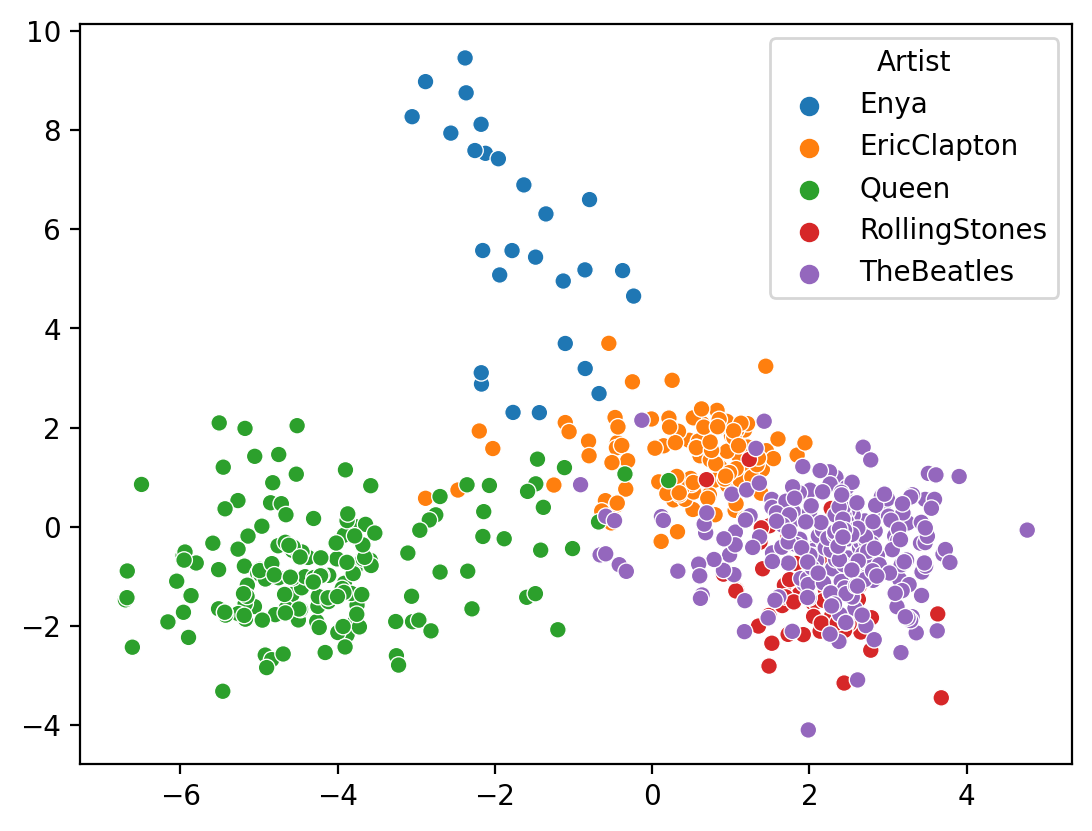

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import seaborn as sns

target = processed_df['Artist']
data = processed_df.drop(columns=['Id', 'WindowId']).select_dtypes([int, float])
data = make_pipeline(StandardScaler(), 
                     VarianceThreshold(0.25),
                     LDA(n_components=2, solver='svd')).fit_transform(data, target)
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=target)

<Axes: >

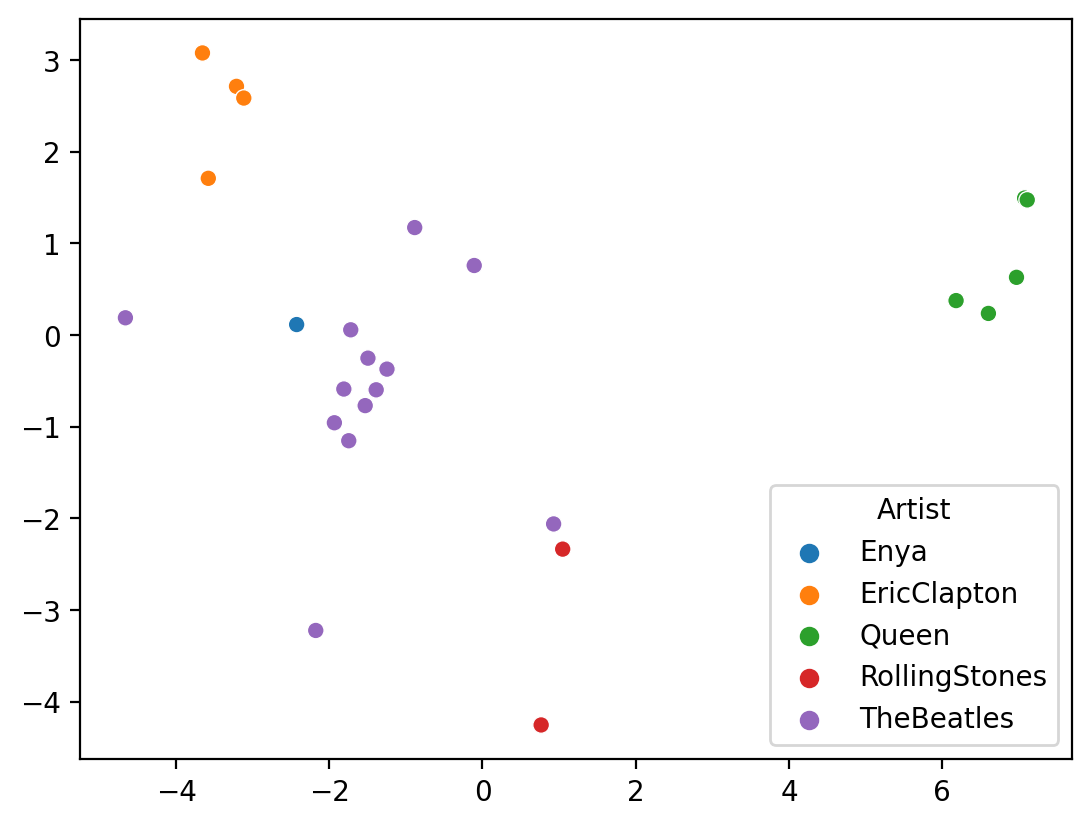

In [ ]:
target = processed_df['Artist'].groupby(level=0).nth(0) # 'Artist' of each window number 0
data = processed_df.drop(columns=['Id', 'WindowId']).select_dtypes([int, float])
data = data.groupby(level=0).mean() # taking the average of the features across the windows here!
data = make_pipeline(StandardScaler(),
                     VarianceThreshold(0.25),
                     LDA(n_components=2, solver='svd')).fit_transform(data, target)
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=target)

In [ ]:
import pandas as pd
import numpy as np

<Axes: >

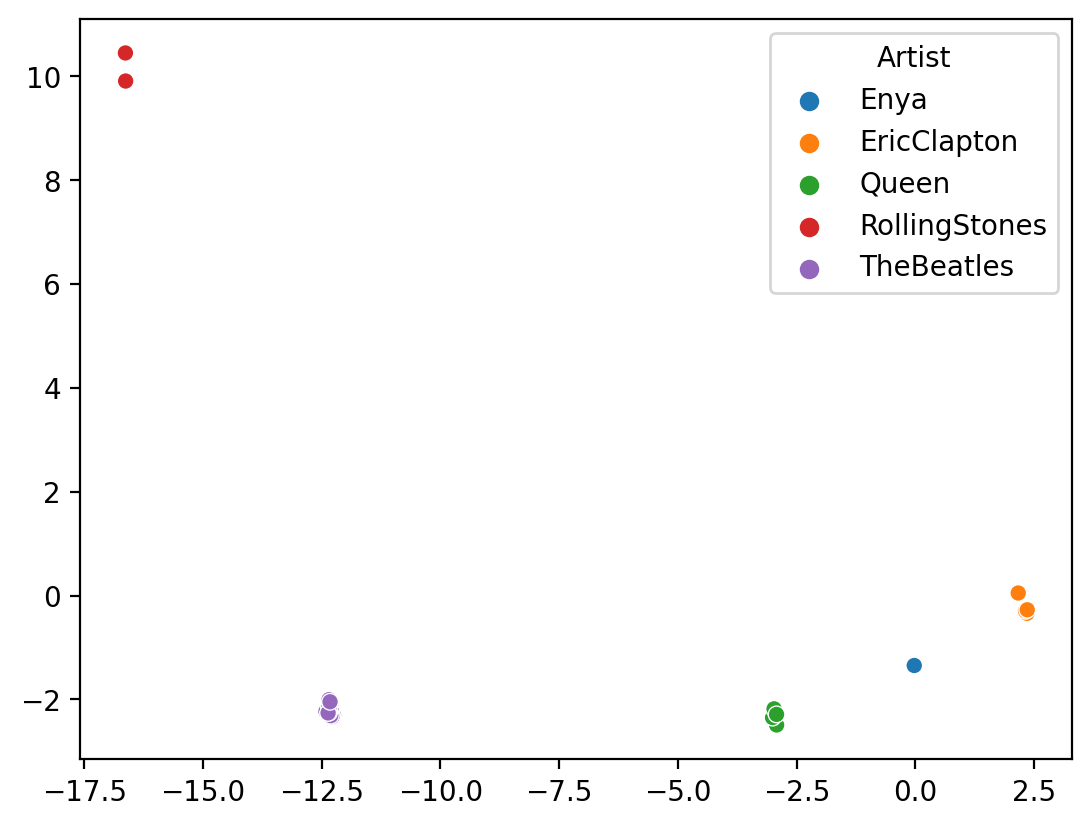

In [ ]:
from scipy.fft import fft
from sklearn.preprocessing import FunctionTransformer

# data selection
target = processed_df.groupby(level=0).nth(0)['Artist']  # 'Artist' of each window number 0
score_groups = processed_df['Id'].to_numpy().astype(str) # groups of samples used for the DCT
data = processed_df.select_dtypes([float, int])          # features

# function to compute the FFT of a score
def compute_fft(x):
    groups = pd.DataFrame(x).groupby(score_groups)
    ret = groups.apply(lambda df: fft(df, n=8, axis=0).mean(axis=0))
    return np.absolute(np.stack(ret.to_list()))

# training model
model = make_pipeline(StandardScaler(), 
                      VarianceThreshold(0.2),
                      FunctionTransformer(compute_fft),
                      LDA(n_components=2, solver='svd'))
data = model.fit_transform(data, target)
sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=target, legend=True)